### Is the data imbalance?

### 2. Data Loader and Custom Data Class

### Define Data Transform Strategy

In [1]:
import os
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
from utils.utils import get_dataloader
from torchvision import datasets, transforms
batch_size = 4
data_path = "/home/endtheme/git/bird-class/data/"
import torchvision.transforms as transform
from torchvision.transforms import v2
import torchvision
train_transformer = transform.Compose([
                           transform.Resize((256, 256)),
                           transform.ToTensor(),
                           transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                               (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
])


test_transformer = transform.Compose([
                           transform.Resize((256, 256)),
                           
                           transform.ToTensor(),
                           transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                               (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
])
shuffle = True
compact = False

train_loader,test_loader = get_dataloader(data_path = data_path, train_transform = train_transformer, test_transform = test_transformer, batch_size = batch_size, shuffle = shuffle, compact = compact)




## 3. Define Metrics  and Loss function

In [3]:
from sklearn import metrics as skmetrics
import numpy
class Metrics:
    def __init__(self, metric_names):
        self.metric_names = metric_names
        # initialize a metric dictionary
        self.metric_dict = {metric_name: [0] for metric_name in self.metric_names}

    def step(self, labels, preds):
        for metric in self.metric_names:
            # get the metric function
            do_metric = getattr(
                skmetrics, metric, "The metric {} is not implemented".format(metric)
            )
            # check if metric require average method, if yes set to 'micro' or 'macro' or 'None'
            try:
                self.metric_dict[metric].append(
                    do_metric(labels, preds, average="macro")
                )
            except:
                self.metric_dict[metric].append(do_metric(labels, preds))

    def epoch(self):
        # calculate metrics for an entire epoch
        avg = [sum(metric) / (len(metric) - 1) for metric in self.metric_dict.values()]
        metric_as_dict = dict(zip(self.metric_names, avg))
        return metric_as_dict

    def last_step_metrics(self):
        # return metrics of last steps
        values = [self.metric_dict[metric][-1] for metric in self.metric_names]
        metric_as_dict = dict(zip(self.metric_names, values))
        return metric_as_dict

In [4]:
train_metrics = Metrics(["accuracy_score","f1_score"])
val_metrics = Metrics(["accuracy_score","f1_score"])

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
criterion = nn.CrossEntropyLoss()

/home/endtheme/miniconda3/envs/bird/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
device

device(type='cpu')

## 4. Define the Model: Transfer Learning

In [7]:
from torchvision import models
from torch import nn
model = models.efficientnet_b4(pretrained=True).cuda()
for param in model.parameters():
    param.requires_grad = False
classifier = nn.Sequential(
    nn.Linear(in_features=model.classifier[1].in_features, out_features=256,bias=True),
    nn.Dropout(),
    nn.Linear(in_features=256, out_features=200,bias=True)
)
model.classifier  = classifier

/home/endtheme/miniconda3/envs/bird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/endtheme/miniconda3/envs/bird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
len(model.features)

9

In [ ]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=2, factor=0.5
    )

## 5. Define a training epoch

In [ ]:
model = model.to(device)

In [ ]:
def train_one_epoch(
    model,
    train_loader,
    test_loader,
    device,
    optimizer,
    criterion,
    train_metrics,
    val_metrics,
):

    # training-the-model
    train_loss = 0
    valid_loss = 0
    all_labels = []
    all_preds = []
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU
        data = data.type(torch.FloatTensor).to(device)
        # target=torch.Tensor(target)
        target = target.float().to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # get the prediction label and target label
        output = model(data)
        preds = torch.argmax(output, axis=1).cpu().detach().numpy()
        labels = target.cpu().numpy()
        # calculate-the-batch-loss
        loss = criterion(output.type(torch.FloatTensor), target.type(torch.LongTensor))
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        # calculate training metrics
        all_labels.extend(labels)
        all_preds.extend(preds)
    
    train_metrics.step(all_labels, all_preds)

    # validate-the-model
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.type(torch.FloatTensor).to(device)
            target = target.to(device)
            output = model(data)
            preds = torch.argmax(output, axis=1).tolist()
            labels = target.tolist()
            all_labels.extend(labels)
            all_preds.extend(preds)
            loss = criterion(output, target)

            # update-average-validation-loss
            valid_loss += loss.item() * data.size(0)

    val_metrics.step(all_labels, all_preds)
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(test_loader.sampler)

    return (
        train_loss,
        valid_loss,
        train_metrics.last_step_metrics(),
        val_metrics.last_step_metrics(),
    )

## 6. Begin Training

In [ ]:
from tqdm import tqdm

In [ ]:

from datetime import datetime
time_str = str(datetime.now().strftime("%Y%m%d-%H%M"))

In [ ]:
num_epoch = 20
best_val_acc = 0
import logging
import numpy as np
print("begin training process")
for i in tqdm(range(0, num_epoch)):
    loss, val_loss, train_result, val_result = train_one_epoch(
        model,
        train_loader,
        test_loader,
        device,
        optimizer,
        criterion,
        train_metrics,
        val_metrics,
    )

    scheduler.step(val_loss)
    print(
        "Epoch {} / {} \n Training loss: {} - Other training metrics: ".format(
            i + 1, num_epoch, loss
        )
    )
    print(train_result)
    print(
        " \n Validation loss : {} - Other validation metrics:".format(val_loss)
    )
    print(val_result)
    print("\n")
    # saving epoch with best validation accuracy
    if best_val_acc < float(val_result["accuracy_score"]):
        print(
            "Validation accuracy= "+
            str(val_result["accuracy_score"])+
            "===> Save best epoch"
        )
        best_val_acc = val_result["accuracy_score"]
        torch.save(
            model.state_dict(),
            "./" +  "best.pt",
        )
    else:
        print(
            "Validation accuracy= "+ str(val_result["accuracy_score"])+ "===> No saving"
        )
        continue

begin training process


  0%|          | 0/20 [00:01<?, ?it/s]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

model = model.to(device)
num_epoch = 20
best_val_acc = 0
import logging
import numpy as np
print("begin training process")
for i in tqdm(range(0, num_epoch)):
    loss, val_loss, train_result, val_result = train_one_epoch(
        model,
        train_loader,
        test_loader,
        device,
        optimizer,
        criterion,
        train_metrics,
        val_metrics,
    )

    scheduler.step(val_loss)
    print(
        "Epoch {} / {} \n Training loss: {} - Other training metrics: ".format(
            i + 1, num_epoch, loss
        )
    )
    print(train_result)
    print(
        " \n Validation loss : {} - Other validation metrics:".format(val_loss)
    )
    print(val_result)
    print("\n")
    # saving epoch with best validation accuracy
    if best_val_acc < float(val_result["accuracy_score"]):
        print(
            "Validation accuracy= "+
            str(val_result["accuracy_score"])+
            "===> Save best epoch"
        )
        best_val_acc = val_result["accuracy_score"]
        torch.save(
            model,
            "./" +  "best.pt"
        )
    else:
        print(
            "Validation accuracy= "+ str(val_result["accuracy_score"])+ "===> No saving"
        )
        continue

begin training process


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20 
 Training loss: 2.7811544230325445 - Other training metrics: 
{'accuracy_score': 0.3452060468005798, 'f1_score': 0.3314216601052612}
 
 Validation loss : 1.8691778682494085 - Other validation metrics:
{'accuracy_score': 0.49916943521594687, 'f1_score': 0.46781488783361647}


Validation accuracy= 0.49916943521594687===> Save best epoch


  5%|▌         | 1/20 [08:06<2:34:01, 486.37s/it]

Epoch 2 / 20 
 Training loss: 2.3365110218660705 - Other training metrics: 
{'accuracy_score': 0.4143715054876786, 'f1_score': 0.4029370088184055}
 
 Validation loss : 1.641051177182962 - Other validation metrics:
{'accuracy_score': 0.5506644518272426, 'f1_score': 0.5237749219611246}


Validation accuracy= 0.5506644518272426===> Save best epoch


 10%|█         | 2/20 [15:40<2:20:08, 467.13s/it]

Epoch 3 / 20 
 Training loss: 2.1645199129067487 - Other training metrics: 
{'accuracy_score': 0.45578794781528265, 'f1_score': 0.4489879439040761}
 
 Validation loss : 1.4955583870011782 - Other validation metrics:
{'accuracy_score': 0.5838870431893688, 'f1_score': 0.554610775526279}


Validation accuracy= 0.5838870431893688===> Save best epoch


 15%|█▌        | 3/20 [23:57<2:16:17, 481.05s/it]

Epoch 4 / 20 
 Training loss: 1.9278205432681272 - Other training metrics: 
{'accuracy_score': 0.5112859805342721, 'f1_score': 0.5056395170456011}
 
 Validation loss : 1.344794825989555 - Other validation metrics:
{'accuracy_score': 0.6320598006644518, 'f1_score': 0.6126905862761699}


Validation accuracy= 0.6320598006644518===> Save best epoch


 20%|██        | 4/20 [31:41<2:06:29, 474.36s/it]

Epoch 5 / 20 
 Training loss: 1.7510669266253087 - Other training metrics: 
{'accuracy_score': 0.5498032718989438, 'f1_score': 0.5446116556036477}
 
 Validation loss : 1.368515004483949 - Other validation metrics:
{'accuracy_score': 0.6353820598006644, 'f1_score': 0.6157800360715996}


Validation accuracy= 0.6353820598006644===> Save best epoch


## Test the results

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import copy
test_model = torch.load("/kaggle/working/best.pt")
test_model = test_model.to(device)


In [ ]:
x_train.dtypes


path     object
label     int64
dtype: object

In [ ]:
def test_result(model, test_loader, device):
    # testing the model by turning model "Eval" mode
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for data, target in test_loader:
            # move-tensors-to-GPU
            data = data.to(device)
            print(target)
            target = target.to(device)
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
            prob = nn.Softmax(dim=1)
            # applying Softmax to results
            probs = prob(output)
            labels.extend(target.tolist())
            preds.extend(torch.argmax(probs, axis=1).tolist())
    return labels,preds


In [ ]:
test_loader

In [ ]:
for data, target in test_loader:
            # move-tensors-to-GPU
            
            print(target)

tensor([4])
tensor([1])
tensor([1])
tensor([3])
tensor([2])
tensor([0])
tensor([4])
tensor([0])
tensor([2])
tensor([3])
tensor([0])
tensor([0])
tensor([0])
tensor([4])
tensor([0])
tensor([2])
tensor([0])
tensor([0])
tensor([4])
tensor([3])
tensor([4])
tensor([1])
tensor([4])
tensor([0])
tensor([2])
tensor([4])
tensor([4])
tensor([1])
tensor([3])
tensor([1])
tensor([3])
tensor([1])
tensor([1])
tensor([4])
tensor([0])
tensor([2])
tensor([2])
tensor([3])
tensor([2])
tensor([0])
tensor([2])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([2])
tensor([2])
tensor([1])
tensor([2])
tensor([3])
tensor([3])
tensor([1])
tensor([1])
tensor([0])
tensor([3])
tensor([3])
tensor([3])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([3])
tensor([2])
tensor([1])
tensor([0])
tensor([2])
tensor([0])
tensor([0])
tensor([4])
tensor([0])
tensor([1])
tensor([4])
tensor([4])
tensor([4])
tensor([1])
tensor([1])
tensor([0])
tensor([4])
tensor([1])
tensor([4])
tensor([1])
tens

In [ ]:
labels,preds =test_result(test_model, test_loader, device)

tensor([4])
tensor([1])
tensor([1])
tensor([3])
tensor([2])
tensor([0])
tensor([4])
tensor([0])
tensor([2])
tensor([3])
tensor([0])
tensor([0])
tensor([0])
tensor([4])
tensor([0])
tensor([2])
tensor([0])
tensor([0])
tensor([4])
tensor([3])
tensor([4])
tensor([1])
tensor([4])
tensor([0])
tensor([2])
tensor([4])
tensor([4])
tensor([1])
tensor([3])
tensor([1])
tensor([3])
tensor([1])
tensor([1])
tensor([4])
tensor([0])
tensor([2])
tensor([2])
tensor([3])
tensor([2])
tensor([0])
tensor([2])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([2])
tensor([2])
tensor([1])
tensor([2])
tensor([3])
tensor([3])
tensor([1])
tensor([1])
tensor([0])
tensor([3])
tensor([3])
tensor([3])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([3])
tensor([2])
tensor([1])
tensor([0])
tensor([2])
tensor([0])
tensor([0])
tensor([4])
tensor([0])
tensor([1])
tensor([4])
tensor([4])
tensor([4])
tensor([1])
tensor([1])
tensor([0])
tensor([4])
tensor([1])
tensor([4])
tensor([1])
tens

In [ ]:
# bpreds = []
# for pred in preds:
#     bpred = [pred]
#     bpreds.append(bpred)
    
# bpreds

In [ ]:
report = classification_report(labels, preds, digits=4,target_names=le.classes_)

cm = confusion_matrix(labels, preds)

In [ ]:
print(report)

              precision    recall  f1-score   support

       daisy     0.9556    0.9389    0.9471       229
   dandelion     0.9590    0.9620    0.9605       316
        rose     0.9730    0.9191    0.9453       235
   sunflower     0.9195    0.9864    0.9518       220
       tulip     0.9527    0.9527    0.9527       296

    accuracy                         0.9522      1296
   macro avg     0.9519    0.9518    0.9515      1296
weighted avg     0.9528    0.9522    0.9521      1296



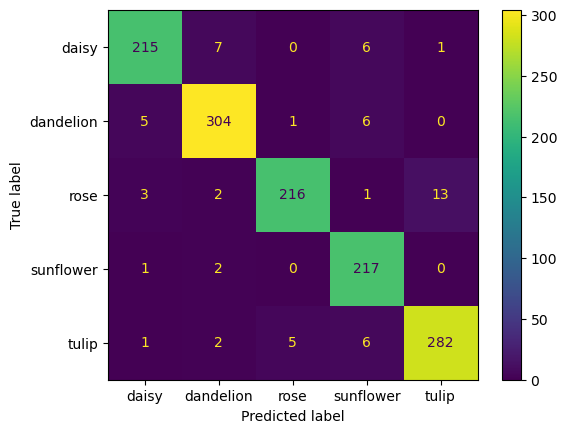

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
disp.plot()

<Axes: >

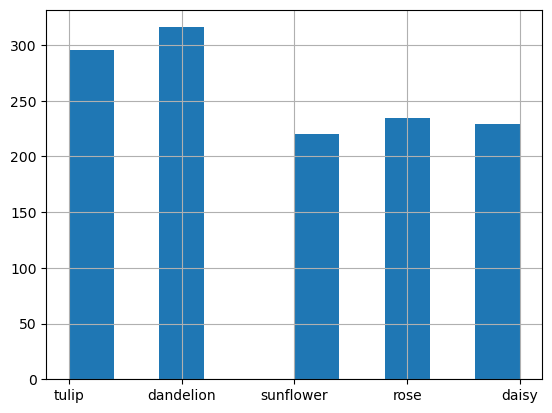

In [ ]:
x_test.label = le.inverse_transform(x_test.label)
x_test.label.hist()

How mixcut work and why we need it?

MixCut: cut a part of the image and paste it into other image, the cut part will also has the label comning along with it
=> it helps the model to focus on less discriminative parts of the object or in other words, prevents model from making prediction solely based on a part of the object